### [ 손글씨 숫자 인식 모델 구현 ]
- 데이터셋 : mnist_train.csv, mnist_test.csv
- 학습종류 : 지도학습 - 다중클래스분류
- 학습방법 : 인공신경망기반 

[1] 모듈로딩 및 데이터 준비<hr>

In [1]:
# [1-1] 모듈로딩
import sys
sys.path.append(r"C:\Users\kwon\Desktop\KDT_10\EX00_DL\Utils")

import torch                                            # 텐서 및 수치과학 함수들 관련 모듈
import torch.nn as nn                                   # 신경망 층 관련 모듈
import torch.nn.functional as F                         # 신경망 함수들(AF, LF, MF) 모듈
import torch.optim as optim                             # 신경망 최적화 모듈

from torch.utils.data import Dataset, DataLoader        # pytorch의 데이터 로딩
from torch.utils.data import Subset                     # pytorch의 데이터셋 관련 모듈
from sklearn.model_selection import train_test_split
import pandas as pd

import util_func as uf                                  # 학습 관련 함수들 


In [2]:
# [1-2] 데이터 준비
TRAIN_FILE = '../Data/mnist_train.csv'
TEST_FILE  = '../Data/mnist_test.csv'

## [1-3] 데이터 로딩
trainDF = pd.read_csv(TRAIN_FILE, header=None)
testDF  = pd.read_csv(TEST_FILE, header=None)


[2] 커스텀 데이터셋 준비 <hr>

In [ ]:
## --------------------------------------------------------------------------------
## [2-1] 커스텀 데이터셋 클래스 정의
## --------------------------------------------------------------------------------
## 클래스이름 : ClfDataset
## 부모클래스 : Dataset
## 오버라이딩 : _ _init_ _(self)        : [필수] 피쳐, 타겟, [선택]행수, 컬럼수, 타겟 수...
##            _ _len_ _(self)          : len() 내장함수 실행 시 자동 호출, 샘플 수 반환
##            _ _getitem_ _(self, idx) : 인스턴스명[idx] 시 자동 호출,
##                                       idx에 해당하는 피쳐, 타겟을 텐서화 해서 반환
## --------------------------------------------------------------------------------
class ClfDataset(Dataset):

    ##- 피쳐와 타겟 저장 및 기타 속성 초기화 
    def __init__(self, dataDF):
        super().__init__()
        ## 피쳐, 타겟 초기화 필수
        self.x = dataDF[dataDF.columns[1:]].values
        self.y = dataDF[dataDF.columns[0]].values


    ##- 데이터 샘플 수 반환 메서드 : len() 함수에 자동호출됨
    def __len__(self):
        return self.x.shape[0] 
    
    ##- 인덱스에 해당하는 피쳐와 타겟 텐서 반환 메서드 : 인스턴스명[index]에 자동호출됨
    def __getitem__(self, index):
        xTS = torch.tensor(self.x[index], dtype=torch.float32)
        yTS = torch.tensor(self.y[index])
        return xTS.reshape(1, 28, 28), yTS



In [4]:
## --------------------------------------------------------------------------------
## [2-2] 커스텀 데이터셋 인스턴스 생성 및 사용
## --------------------------------------------------------------------------------
allDS   = ClfDataset(trainDF)
testDS  = ClfDataset(testDF)

print(f'allDS : {len(allDS)},  testDS : {len(testDS)}')
print(testDS[0][0].shape)

allDS : 60000,  testDS : 10000
torch.Size([1, 28, 28])


In [5]:
a2 = testDS[0][0].reshape(1, 28, 28)
#a2.unsqueeze_(0).shape    ## tensor.메서드_() : inplace=True의미
a2.shape

torch.Size([1, 28, 28])

In [6]:
## [2-3] 학습용/검증용/테스트용 데이터셋 분리

## 학습용 데이터셋에서 타겟/라벨만 추출 
targetList    = allDS.y 
dataIndexList = list( range(len(allDS)))

## 학습용/검증용 데이터셋 인덱스 분리
## -train_test_split() 함수 : train:test = 75:25 비율로 학습용, 테스트용 데이터셋 분리
##                            stratify : 분류용 데이터셋 경우 카테고리 비율 유지해서
##                                       데이터셋 분리
X_trainIdx, X_validIdx , y_train, y_valid = train_test_split( dataIndexList,
                                                              targetList,
                                                              train_size=0.8,
                                                              stratify=targetList,
                                                              random_state=10 )


In [7]:
## -----------------------------------------------------------------
## 학습용/검증용 데이터셋 생성 ===> Dataset ==> 2개 Subset 분리
## -----------------------------------------------------------------
trainDS = Subset(allDS, X_trainIdx)
validDS = Subset(allDS, X_validIdx)

print(f'allDS   : {type(allDS)},   {len(allDS)}개')
print(f'trainDS : {type(trainDS)}, {len(trainDS)}개')
print(f'validDS : {type(validDS)}, {len(validDS)}개')

allDS   : <class '__main__.ClfDataset'>,   60000개
trainDS : <class 'torch.utils.data.dataset.Subset'>, 48000개
validDS : <class 'torch.utils.data.dataset.Subset'>, 12000개


In [8]:
trainDS[0][0].shape

torch.Size([1, 28, 28])

[3] 모델 클래스 설계 <hr>

In [16]:
## --------------------------------------------------------------------------------
## [3-1] 커스텀 모델 클래스 정의
## --------------------------------------------------------------------------------
##               입력                커널     패딩     스트라이드      출력              활성화함수  
##  입력층   (BS, 1, 28, 28)          -                             (BS, 1,  28, 28)        -
##  conv    (BS, 1, 28, 28)         3x3 10     X       (1, 1)      (BS, 10, 26, 26)     relu
##  pool    (BS, 10, 26, 26)        2x2 1      x       (2, 2)      (BS, 10, 13, 13)        - 
##  flatten (BS, 10, 13, 13)                                       (BS, 10 *13 *13)        -
##  출력층   (BS, 10 *13 *13)     퍼셉트론 10    X          X        (BS, 10 )          손실함수따라  
## --------------------------------------------------------------------------------
## 클래스이름 : MNISTModel
## 부모클래스 : nn.Module
## 오버라이딩 : __init__()
##            forward()
## --------------------------------------------------------------------------------
class MNISTModel(nn.Module):
    ##- 인공신경망 구성 층 생성 및 초기화 함수
    def __init__(self):
        super().__init__()   ## 부모 즉, 슈퍼클래스 생성
        self.conv_layer     =nn.Conv2d(1, 10, 3)    ## 흑백이미지, 커널 10개, 커널 3x3, 스트라이드 1, 패딩 X
        self.pool_layer     =nn.MaxPool2d(2, 2)     ## Downsampling 크기 즉, 행과 열 1/2 줄임
        self.flatten_layer  =nn.Flatten()           ## 4D(BS, C, H, W) -> 2D (BS, C * H * W)
        self.fc_layer       =nn.Linear(1690, 10)    ## (C * H * W, 10) 

    ##- 순방향 학습 진행 함수
    def forward(self, data):
        #- data 입력층 -> 은닉층 1 : Conv2D
        out = self.conv_layer(data)  
        out = F.relu(out)           
        #print(f'Conv : {out.shape}')

        #- 은닉층 2 : MaxPooling2D
        out = self.pool_layer(out)  
        #print(f'Pool : {out.shape}')

        #- 은닉층 3 : Flatten
        out = self.flatten_layer(out)  
        #print(f'Flatten : {out.shape}')

        #- 출력층
        out = self.fc_layer(out)   
        return out              

In [17]:
## --------------------------------------------------------------------------------
## [3-2] 커스텀 모델 클래스 구조 확인 => torchinfo 활용
## --------------------------------------------------------------------------------
from torchinfo import summary

summary(MNISTModel(), input_size=(1, 1, 28, 28))



Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 26, 26]           100
├─MaxPool2d: 1-2                         [1, 10, 13, 13]           --
├─Flatten: 1-3                           [1, 1690]                 --
├─Linear: 1-4                            [1, 10]                   16,910
Total params: 17,010
Trainable params: 17,010
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.07
Estimated Total Size (MB): 0.13

[4] 학습 준비<hr>

In [18]:
## ------------------------------------------------------------
## [4-1] 학습 관련 설정
## ------------------------------------------------------------
## 학습 진행 횟수 및 학습량, 학습 진행 위치, W/b 업데이트 간격
EPOCHS      = 100
BATCH_SIZE  = 500
LR          = 0.01
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'


In [19]:
## ------------------------------------------------------------
## [4-2] 학습 관련 인스턴스 생성
## ------------------------------------------------------------
## -> Model 인스턴스  : 자동으로 층별 W, b 텐서 생성 및 랜덤 초기화 
## -> to(DEVICE)     : 모델 안의 파라미터/버퍼 텐서(weight, bias 등) DEVICE(예: GPU)로 복사
##                     CPU → GPU 메모리 복. GPU 메모리에 새 텐서 생성
model = MNISTModel().to(DEVICE)

## -> 손실함수 인스턴스 : 다중분류용 
lossFn = nn.CrossEntropyLoss()

## -> 최적화  인스턴스  : 모델의 층별 파라미터 즉, W,b 업데이트 
optimizer = optim.Adam(model.parameters(), lr = LR )

## -> 데이터로더 인스턴스 : 학습/검증/테스트에 사용될 학습량 만큼 데이터 추출
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE)
testDL  = DataLoader(testDS,  batch_size=BATCH_SIZE)


In [20]:
for xTS, yTS in trainDL:
    print(xTS.shape)
    break

torch.Size([500, 1, 28, 28])


[5] 학습 진행<hr>

In [21]:
### ===> 학습진행
## - 학습과 검증 결과 저장 : 학습 진행/중단 여부 결정
HISTORY = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

## - 지정된 학습 횟수 만큼 학습 진행 & 에포크 단위로 학습과 검증 결과 저장 
for epoch in range(EPOCHS):
    ## 1에포크 학습
    train_loss, train_acc = uf.train_one_epoch(model, trainDL, lossFn, optimizer, DEVICE)

    ## 1에포크 학습 후 업데이트 W,b 검사 : 학습에 사용되지 않는 데이터
    valid_loss, valid_acc = uf.evaluate(model, validDL, lossFn, DEVICE)

    ## 학습과 검증 결과 저장 
    HISTORY['train_loss'].append(train_loss)
    HISTORY['train_acc'].append(train_acc)
    HISTORY['val_loss'].append(valid_loss)
    HISTORY['val_acc'].append(valid_acc)

    ## 진행 상황 출력
    ## [EPOCH-1] TRAIN => Loss : xxx   Acc : xxx   VALID => Loss : xxx   Acc : xxx
    print( f'[EPOCH-{epoch:03}] LOSS => Train : {train_loss:.7f}  Valid : {valid_loss:.7f}  Acc => Train : {train_acc:.5f}' , end='')
    print( f'  Valid : {valid_acc:.5f}' )
    

[EPOCH-000] LOSS => Train : 13.2771080  Valid : 0.4586222  Acc => Train : 0.77496  Valid : 0.88233
[EPOCH-001] LOSS => Train : 0.3334829  Valid : 0.3010332  Acc => Train : 0.90635  Valid : 0.91258
[EPOCH-002] LOSS => Train : 0.2391560  Valid : 0.2405428  Acc => Train : 0.92858  Valid : 0.93033
[EPOCH-003] LOSS => Train : 0.1899797  Valid : 0.2129828  Acc => Train : 0.94219  Valid : 0.93825
[EPOCH-004] LOSS => Train : 0.1595237  Valid : 0.1898152  Acc => Train : 0.95221  Valid : 0.94450
[EPOCH-005] LOSS => Train : 0.1386450  Valid : 0.1747320  Acc => Train : 0.95852  Valid : 0.94567
[EPOCH-006] LOSS => Train : 0.1235031  Valid : 0.1694742  Acc => Train : 0.96231  Valid : 0.94900
[EPOCH-007] LOSS => Train : 0.1124651  Valid : 0.1657317  Acc => Train : 0.96592  Valid : 0.95092
[EPOCH-008] LOSS => Train : 0.1024127  Valid : 0.1574547  Acc => Train : 0.96871  Valid : 0.95442
[EPOCH-009] LOSS => Train : 0.0962260  Valid : 0.1556550  Acc => Train : 0.97029  Valid : 0.95483
[EPOCH-010] LOSS =>

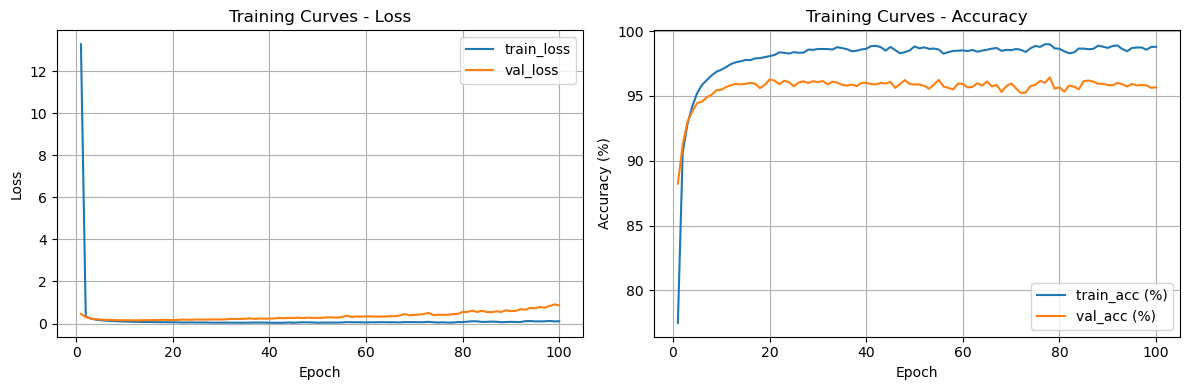

In [22]:
uf.plot_history(HISTORY)